In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [2]:
# Carregamento do dataset
df_tempodist = pd.read_csv('../data/tempodist.csv', delimiter=',')
df_tempodist

# Características das variáveis do dataset
df_tempodist.info()

# Estatísticas univariadas
df_tempodist.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tempo      10 non-null     int64
 1   distancia  10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes


,tempo,distancia
count,10.00000,10.000000
mean,30.00000,17.000000
std,14.90712,9.510228
min,10.00000,5.000000
25%,20.00000,8.750000
50%,27.50000,17.500000
75%,38.75000,23.750000
max,55.00000,32.000000


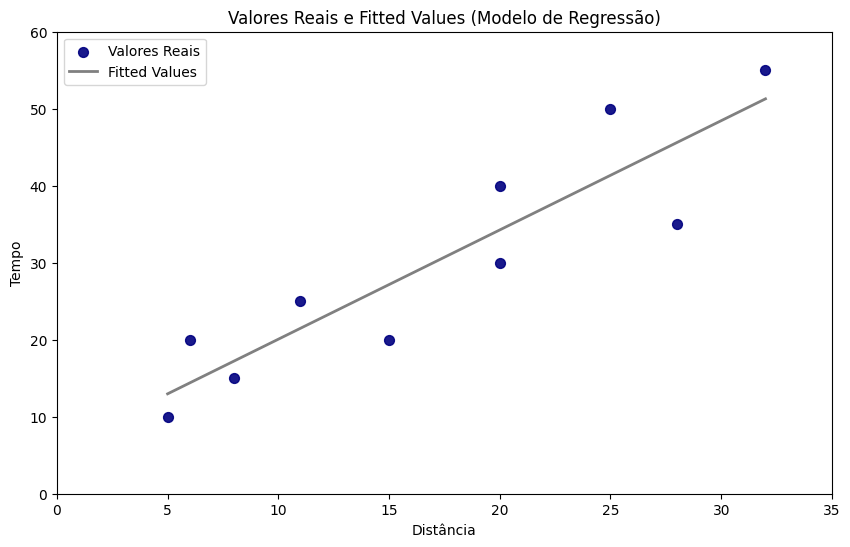

In [30]:
# Gráfico de dispersão com o ajuste linear (fitted values de um modelode regressão) 
# que se adequa às observações: função 'regplot' do pacote 'seaborn'

plt.figure(figsize=(10,6))
sns.regplot(data=df_tempodist, x='distancia', y='tempo', marker='o', ci=False,
            scatter_kws={"color":'navy', 'alpha':0.9, 's':50},
            line_kws={"color":'grey', 'linewidth': 2})
plt.title('Valores Reais e Fitted Values (Modelo de Regressão)', fontsize=12)
plt.xlabel('Distância', fontsize=10)
plt.ylabel('Tempo', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values'], fontsize=10, loc='upper left')
plt.show()

O método para estimação dos parâmetros do modelo deve atender a 2 requisitos fundamentais:

    -   Soma dos erros = 0;
    -   Soma dos erros elevados ao quadrado deve ser a minima;
    -   Variável dependente Y deve ser quantitativa.

A isso dá-se o nome de Mínimos Quadrados Ajustados (MQO), ou Ordinary Least Squares (OLS)

In [15]:
# Gráfico de dispersão

# Dados do gráfico
x = df_tempodist['distancia']
y = df_tempodist['tempo']

# Definição da regressão linear
slope, intercept = np.polyfit(x, y, 1)
y_trend = slope * x + intercept

fig = go.Figure()

# Inserção dos pontos (valores reais)
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(color='navy', size=20), name='Valores Reais')
    )

# Inserção da reta (fitted values)
fig.add_trace(go.Scatter(
    x=x,
    y=y_trend,
    mode='lines',
    line=dict(color='dimgray', width=5), name='Fitted Values')
    )

# Configurações de layout
fig.update_layout(
    xaxis_title='Distância',
    yaxis_title='Tempo',
    title={
        'text': 'Gráfico de Dispersão com Fitted Values',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'},
        'x': 0.5,
        'y': 0.97,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    plot_bgcolor='snow',
    xaxis=dict(gridcolor='black'),
    yaxis=dict(gridcolor='black'),
    showlegend=True
)

fig.show()

In [16]:
# Estimação do modelo de regressão linear simples

# Estimação do modelo
modelo = sm.OLS.from_formula('tempo ~ distancia', df_tempodist).fit()

In [17]:
# Salvando fitted values (variável yhat) e residuals (variável erro) no dataset

df_tempodist['yhat'] = modelo.fittedvalues
df_tempodist['erro'] = modelo.resid
df_tempodist

,tempo,distancia,yhat,erro
0,15,8,17.229730,-2.229730
1,20,6,14.391892,5.608108
2,20,15,27.162162,-7.162162
3,40,20,34.256757,5.743243
4,50,25,41.351351,8.648649
5,25,11,21.486486,3.513514
6,10,5,12.972973,-2.972973
7,55,32,51.283784,3.716216
8,35,28,45.608108,-10.608108
9,30,20,34.256757,-4.256757


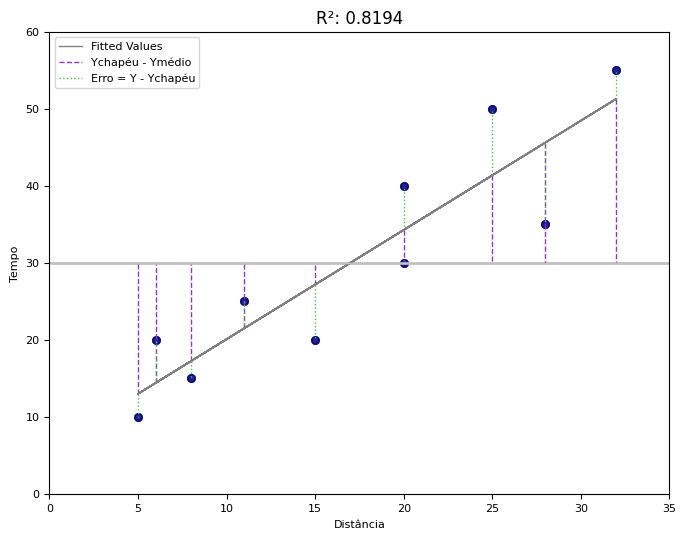

In [31]:
# Gráfico didático para visualizar o conceito de R²

plt.figure(figsize=(8,6))
y = df_tempodist['tempo']
yhat = df_tempodist['yhat']
x = df_tempodist['distancia']
mean = np.full(x.shape[0] , y.mean(), dtype=int)

for i in range(len(x)-1):
    plt.plot(x, yhat, color='grey', linewidth=1)
    plt.plot([x[i], x[i]], [yhat[i], mean[i]], '--', color='darkorchid', linewidth=1)
    plt.plot([x[i], x[i]], [yhat[i], y[i]],':', color='limegreen', linewidth=1)
    plt.scatter(x, y, color='navy', s=30, alpha=0.2)
    plt.axhline(y = y.mean(), color = 'silver', linestyle = '-', linewidth=1)
    plt.title('R²: ' + str(round(modelo.rsquared, 4)), fontsize=12)
    plt.xlabel('Distância', fontsize=8)
    plt.ylabel('Tempo', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(0, 35)
    plt.ylim(0, 60)
    plt.legend(['Fitted Values', 'Ychapéu - Ymédio', 'Erro = Y - Ychapéu'],
               fontsize=8, loc='upper left')
plt.show()

O R² se Calcula através da relação entre soma da diferença quadrática entre Y previsto e Y médio e a soma dos resíduos ao quadrado. Por isso se os resíduos forem iguais a zero o modelo terá um R² igual a 100%.

Abaixo a fórmula da equação:

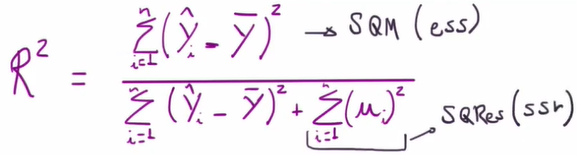

In [27]:
# Cálculo manual do R²

R2 = ((df_tempodist['yhat']-
       df_tempodist['tempo'].mean())**2).sum()/(((df_tempodist['yhat']-
                                        df_tempodist['tempo'].mean())**2).sum()+
                                        (df_tempodist['erro']**2).sum())

round(R2,4)

np.float64(0.8194)

In [29]:
# In[1.7]: Coeficiente de ajuste (R²) é a correlação ao quadrado

# Correlação de Pearson
df_tempodist[['tempo','distancia']].corr()

# R²
(df_tempodist[['tempo','distancia']].corr())**2

# R² de maneira direta
print(f"R2: {modelo.rsquared}")

R2: 0.8194256756756757


*Para modelos de regressão simples a correlação de Pearson ao quadrado é igual ao R²*

**Apesar de o R² e os parâmetros alfa (intercepto) e beta (inclinação/slope) trazerem muitos insights sobre a qualidade do modelo de regressão linear, eles sozinhos não são o suficiente, é necessário avaliar a significância estatística dos parâmetros**

In [13]:
# Observação dos parâmetros resultantes da estimação
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  tempo   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     36.30
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           0.000314
Time:                        06:57:42   Log-Likelihood:                -32.123
No. Observations:                  10   AIC:                             68.25
Df Residuals:                       8   BIC:                             68.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784      4.532      1.297      0.2

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.



*A cada km percorrido, aumenta-se o tempo de percurso em 1,418 minutos!!!*

In [16]:
# Modelo auxiliar para mostrar R² igual a 100% (para fins didáticos)

# Estimação do modelo com yhat como variável dependente resultará em um modelo
#com R² igual a 100%
modelo_auxiliar = sm.OLS.from_formula('yhat ~ distancia', df_tempodist).fit()

# Parâmetros resultantes da estimação deste modelo didático
print(modelo_auxiliar.summary())

                            OLS Regression Results                            
Dep. Variable:                   yhat   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.598e+31
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.72e-122
Time:                        07:00:33   Log-Likelihood:                 309.16
No. Observations:                  10   AIC:                            -614.3
Df Residuals:                       8   BIC:                            -613.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784   6.83e-15   8.61e+14      0.0

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.



*Apesar de todos os pontos do dataset terem mudado para um ajuste perfeito a reta os valores de alfa e beta permanecem os mesmo!*

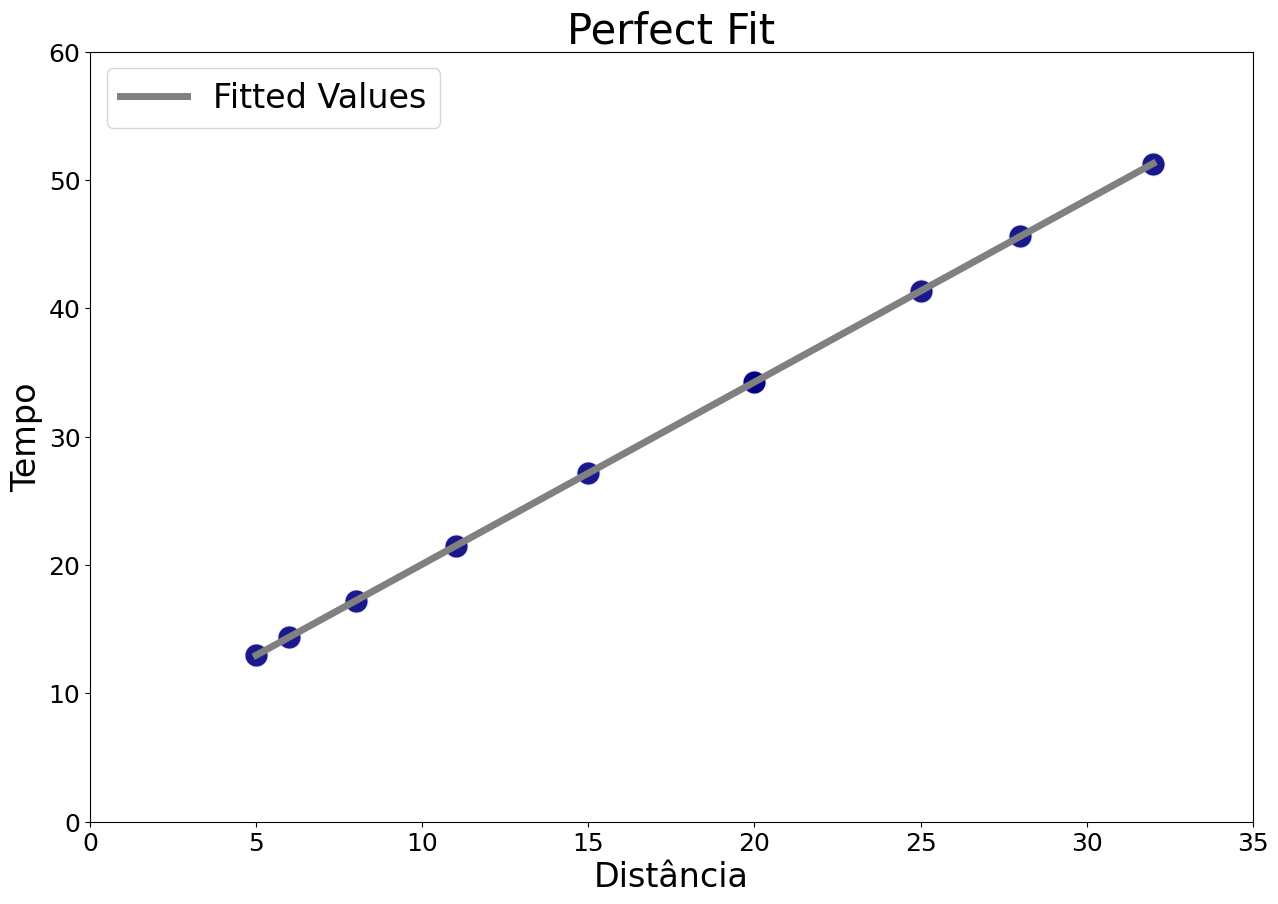

In [21]:
# Gráfico mostrando o perfect fit

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_tempodist, x='distancia', y='yhat',
                color='navy', alpha=0.9, s=300)
sns.regplot(data=df_tempodist, x='distancia', y='yhat', ci=False, scatter=False,
            label='Fitted Values',
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('Perfect Fit', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(loc='upper left', fontsize=24)
plt.show()

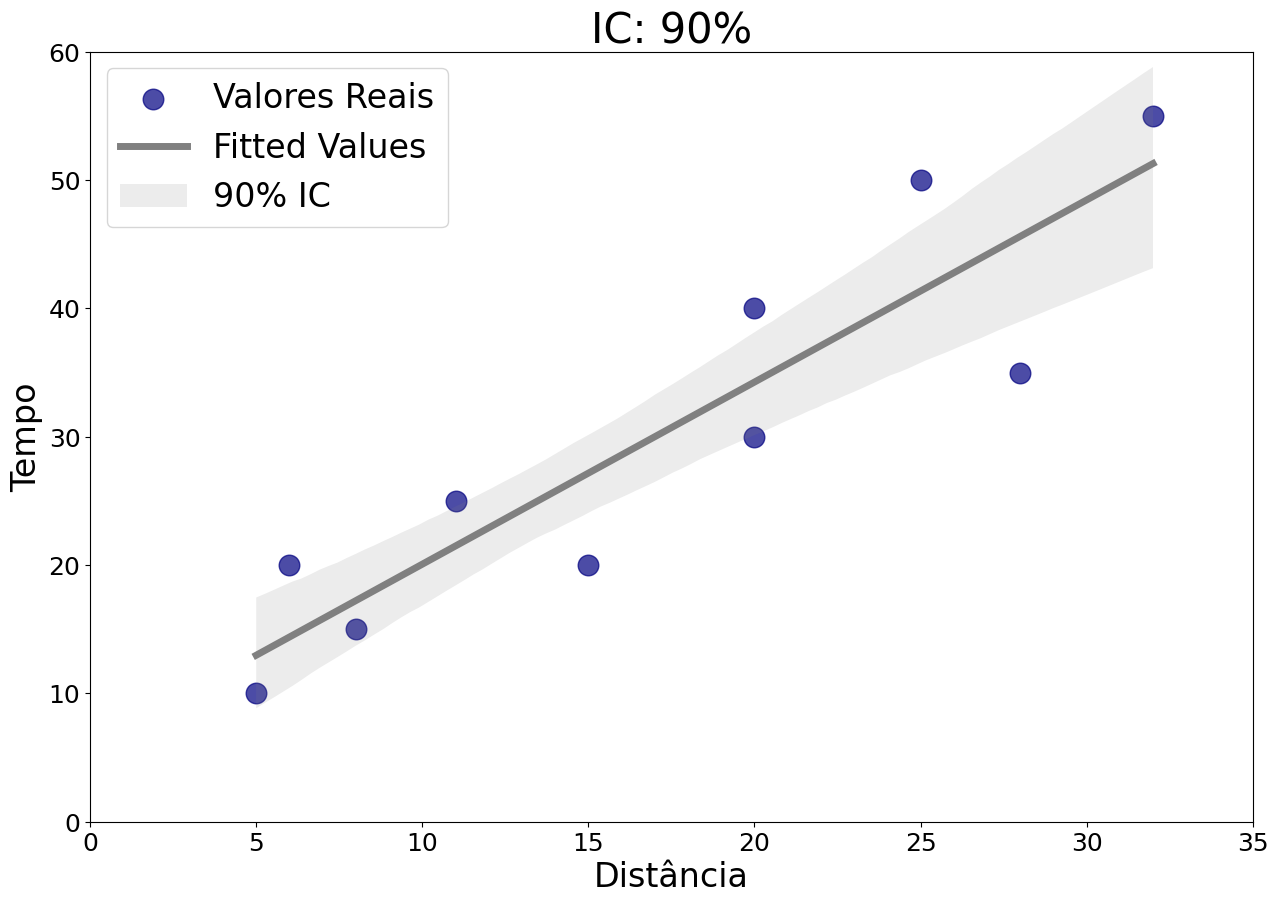

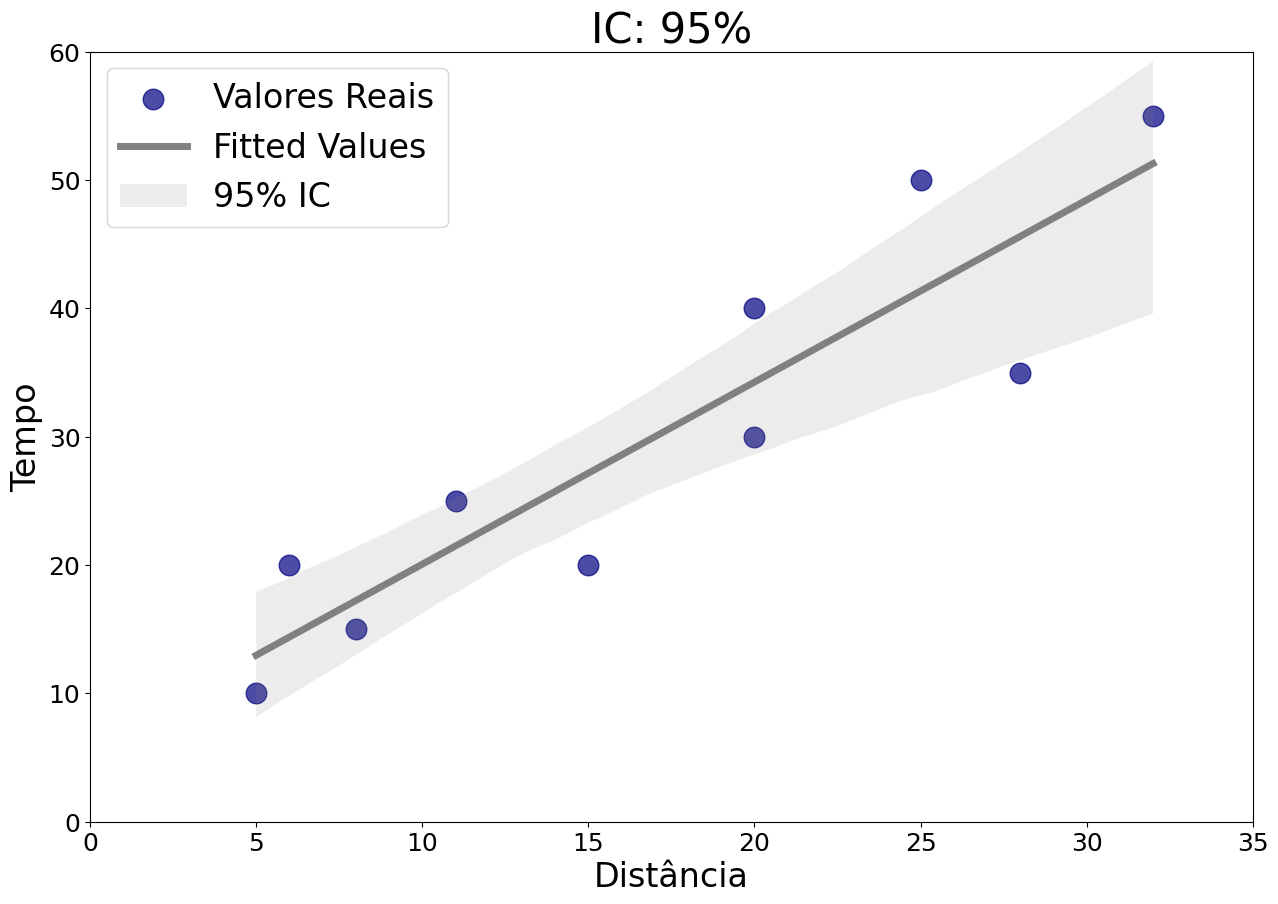

In [20]:
# Voltando ao nosso modelo original

# Gráfico com intervalo de confiança de 90%

plt.figure(figsize=(15,10))
sns.regplot(data=df_tempodist, x='distancia', y='tempo', marker='o', ci=90,
            scatter_kws={"color":'navy', 'alpha':0.7, 's':220},
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('IC: 90%', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values', '90% IC'],
           fontsize=24, loc='upper left')
plt.show

# In[1.12]: Gráfico com intervalo de confiança de 95%

plt.figure(figsize=(15,10))
sns.regplot(data=df_tempodist, x='distancia', y='tempo', marker='o', ci=95,
            scatter_kws={"color":'navy', 'alpha':0.7, 's':220},
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('IC: 95%', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values', '95% IC'],
           fontsize=24, loc='upper left')
plt.show()

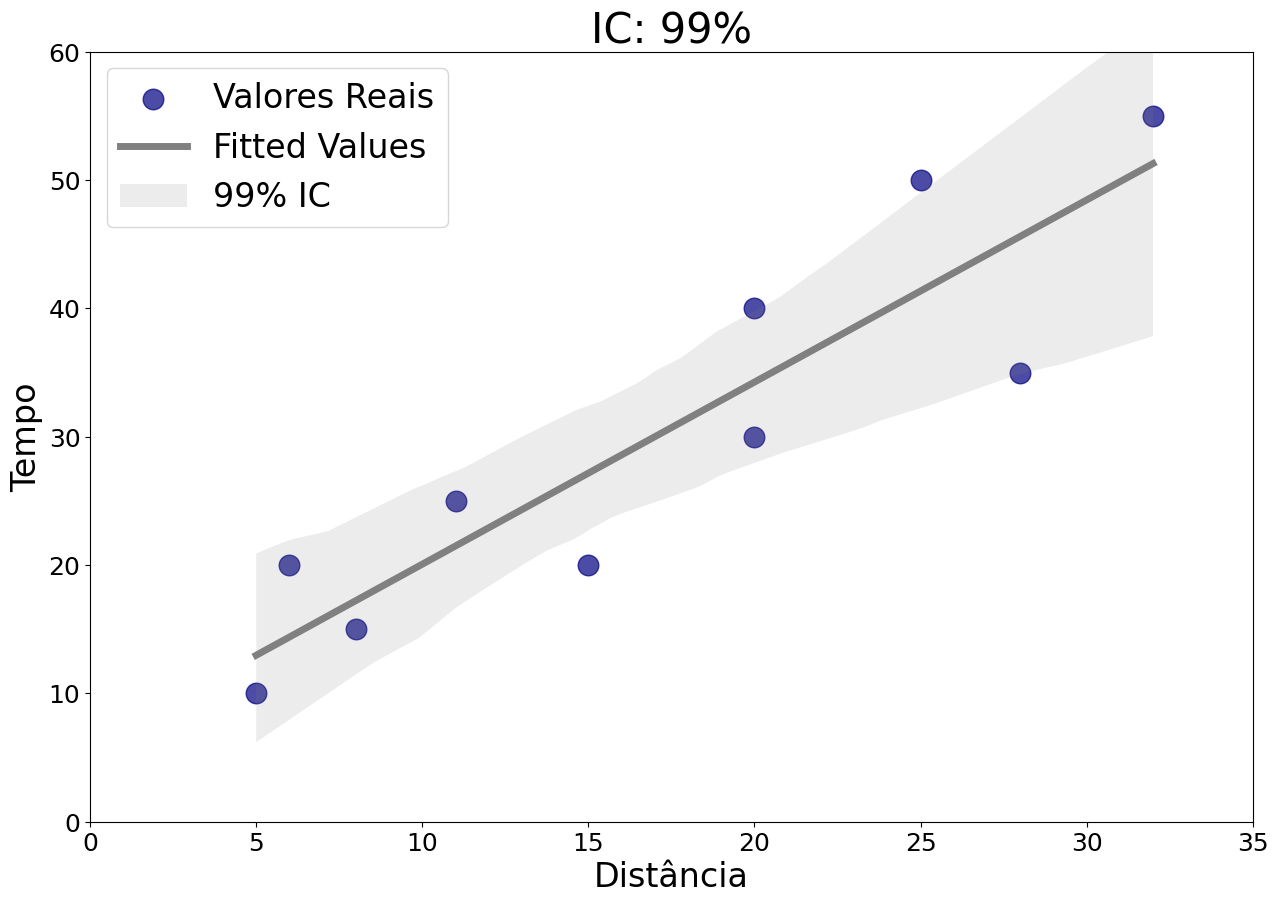

In [19]:
# Gráfico com intervalo de confiança de 99%

plt.figure(figsize=(15,10))
sns.regplot(data=df_tempodist, x='distancia', y='tempo', marker='o', ci=99,
            scatter_kws={"color":'navy', 'alpha':0.7, 's':220},
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('IC: 99%', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values', '99% IC'],
           fontsize=24, loc='upper left')
plt.show()

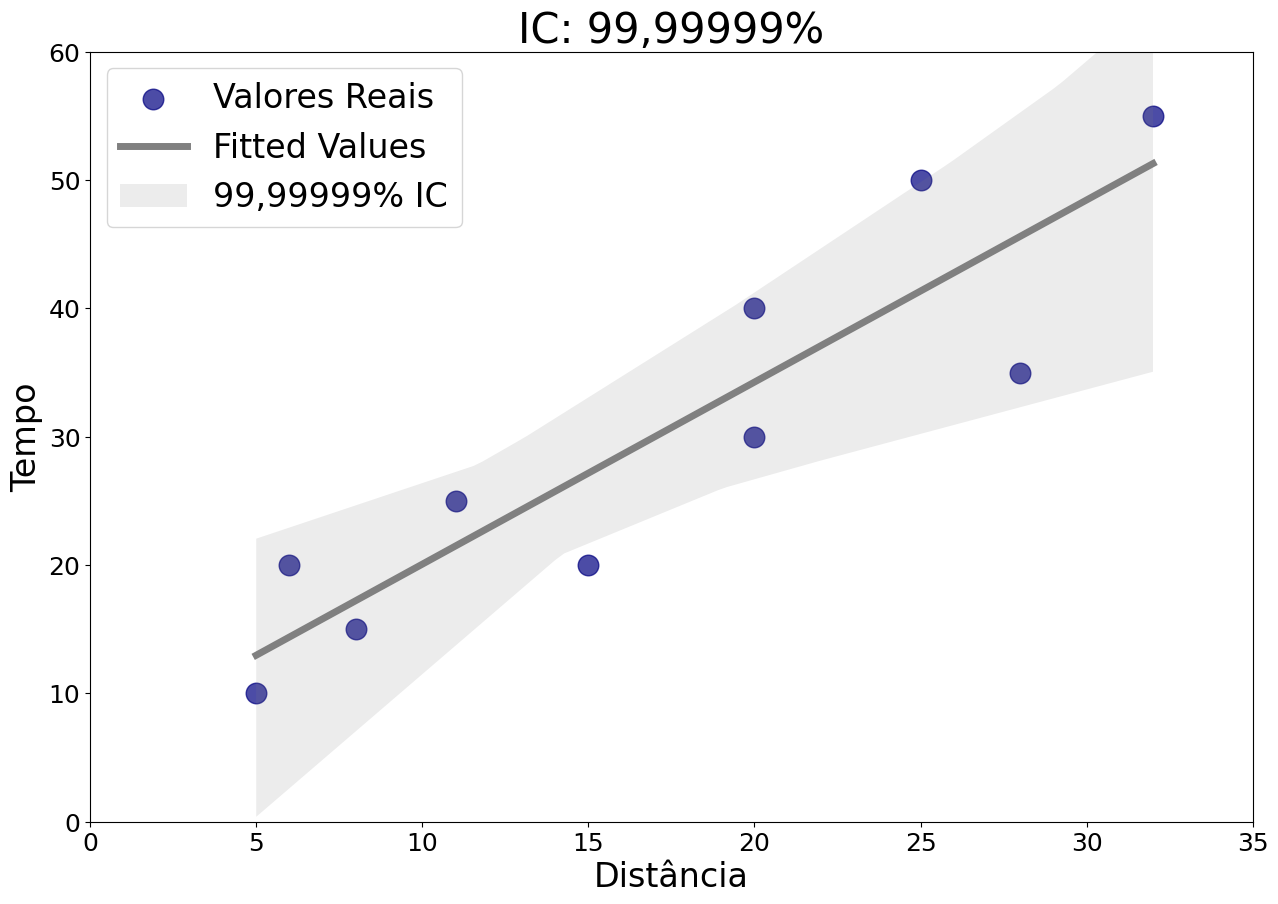

In [22]:
# Gráfico com intervalo de confiança de 99,99999%

plt.figure(figsize=(15,10))
sns.regplot(data=df_tempodist, x='distancia', y='tempo', marker='o', ci=99.99999,
            scatter_kws={"color":'navy', 'alpha':0.7, 's':220},
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('IC: 99,99999%', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values', '99,99999% IC'],
           fontsize=24, loc='upper left')
plt.show()

In [32]:
# Calculando os intervalos de confiança

# Nível de significância de 10% / Nível de confiança de 90%
modelo.conf_int(alpha=0.1)

# Nível de significância de 1% / Nível de confiança de 99%
modelo.conf_int(alpha=0.01)

# Nível de significância de 0,00001% / Nível de confiança de 99,99999%
modelo.conf_int(alpha=0.0000001)

# Nível de significância de 5% / Nível de confiança de 95%
modelo.conf_int(alpha=0.05)

,0,1
Intercept,-4.573188,16.329944
distancia,0.875861,1.961977


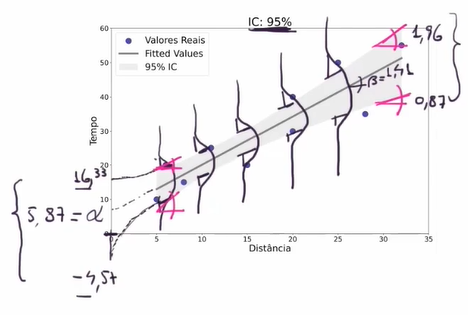

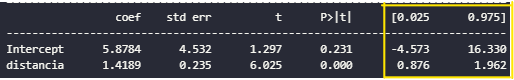

Na prática como funciona a estimação dos parâmetros, no gráfico mostra por que alfa é estatísticamente insignificante pois contém 0

In [25]:
# Fazendo predições em modelos utilizando estimação OLS
# Ex.: Qual seria o tempo gasto, em média, para percorrer a distância de 25km?

# Cálculo manual
5.8784 + 1.4189*(25)

intercept = modelo.params.iloc[0]
beta = modelo.params.iloc[1]
# Cálculo utilizando os próprios parâmetros estimados do modelo
intercept + beta*(25)

# Maneira direta utilizando a função 'DataFrame' do pacote 'pandas' dentro
#da função 'predict'
modelo.predict(pd.DataFrame({'distancia':[25]}))

0    41.351351
dtype: float64

In [26]:
# Nova modelagem para o mesmo exemplo, com novo dataset que
# contém replicações

# Quantas replicações de cada linha você quer? -> função 'repeat' do 'numpy'
df_replicado = pd.DataFrame(np.repeat(df_tempodist.values, 3, axis=0))
df_replicado.columns = df_tempodist.columns
df_replicado

,tempo,distancia,yhat,erro
0,15.0,8.0,17.229730,-2.229730
1,15.0,8.0,17.229730,-2.229730
2,15.0,8.0,17.229730,-2.229730
3,20.0,6.0,14.391892,5.608108
4,20.0,6.0,14.391892,5.608108
5,20.0,6.0,14.391892,5.608108
6,20.0,15.0,27.162162,-7.162162
7,20.0,15.0,27.162162,-7.162162
8,20.0,15.0,27.162162,-7.162162
9,40.0,20.0,34.256757,5.743243


In [27]:
# Estimação do modelo com valores replicados

modelo_replicado = sm.OLS.from_formula('tempo ~ distancia',
                                       df_replicado).fit()

# Parâmetros do 'modelo_replicado'
print(modelo_replicado.summary())

                            OLS Regression Results                            
Dep. Variable:                  tempo   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     127.1
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           6.42e-12
Time:                        07:05:52   Log-Likelihood:                -96.369
No. Observations:                  30   AIC:                             196.7
Df Residuals:                      28   BIC:                             199.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784      2.423      2.426      0.0

In [28]:
# Calculando os novos intervalos de confiança

# Nível de significância de 5% / Nível de confiança de 95%
modelo_replicado.conf_int(alpha=0.05)

,0,1
Intercept,0.915844,10.840913
distancia,1.161068,1.676769


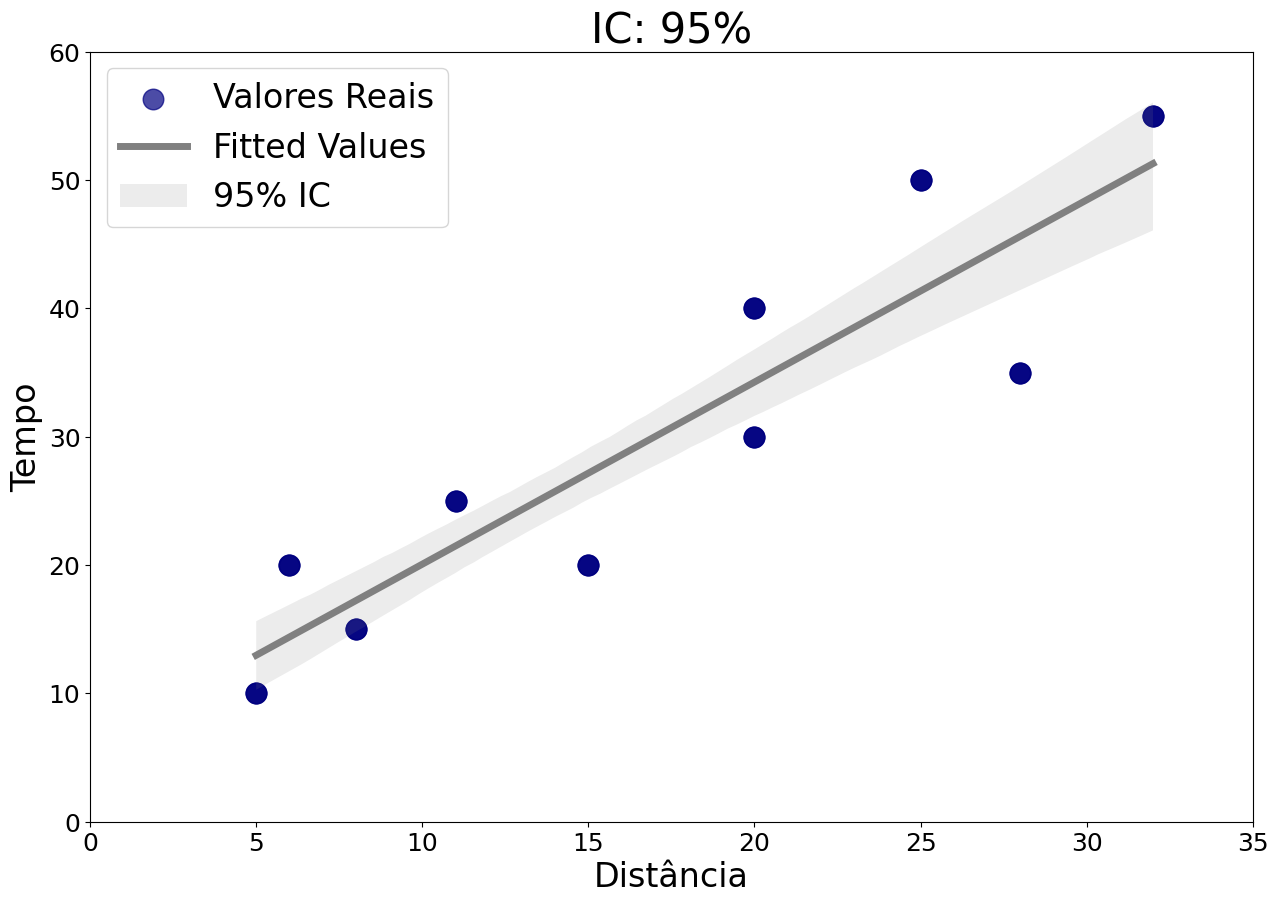

In [29]:
# Plotando o novo gráfico com intervalo de confiança de 95%
# Note o estreitamento da amplitude dos intervalos de confiança!

plt.figure(figsize=(12,10))
sns.regplot(data=df_replicado, x='distancia', y='tempo', marker='o', ci=95,
            scatter_kws={"color":'navy', 'alpha':0.7, 's':220},
            line_kws={"color":'grey', 'linewidth': 5})
plt.title('IC: 95%', fontsize=30)
plt.xlabel('Distância', fontsize=24)
plt.ylabel('Tempo', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Reais', 'Fitted Values', '95% IC'],
           fontsize=24, loc='upper left')
plt.show()

In [30]:
# PROCEDIMENTO ERRADO: ELIMINAR O INTERCEPTO QUANDO ESTE NÃO SE
# MOSTRAR ESTATISTICAMENTE SIGNIFICANTE

modelo_errado = sm.OLS.from_formula('tempo ~ 0 + distancia', df_tempodist).fit()

# Parâmetros do 'modelo_errado'
print(modelo_errado.summary())

                                 OLS Regression Results                                
Dep. Variable:                  tempo   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              217.5
Date:                Fri, 09 Aug 2024   Prob (F-statistic):                    1.31e-07
Time:                        07:06:08   Log-Likelihood:                         -33.077
No. Observations:                  10   AIC:                                      68.15
Df Residuals:                       9   BIC:                                      68.46
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.



In [31]:
# Comparando os parâmetros do modelo inicial (objeto 'modelo')
# com o 'modelo_errado' pela função 'summary_col' do pacote
# 'statsmodels.iolib.summary2'

summary_col([modelo, modelo_errado])

# Outro modo mais completo também pela função 'summary_col'
summary_col([modelo, modelo_errado],
            model_names=["MODELO INICIAL","MODELO ERRADO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

,MODELO INICIAL,MODELO ERRADO
Intercept,5.8784,
,(4.5323),
distancia,1.4189***,1.6887***
,(0.2355),(0.1145)
R-squared,0.8194,0.9603
R-squared Adj.,0.7969,0.9558
N,10,10


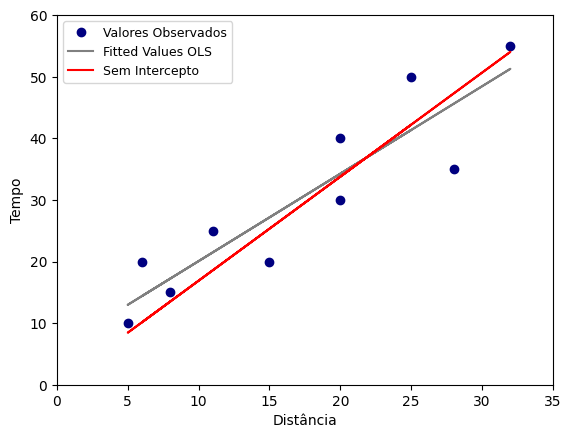

In [32]:
# Gráfico didático para visualizar o viés decorrente de se eliminar
# erroneamente o intercepto em modelos regressivos

x = df_tempodist['distancia']
y = df_tempodist['tempo']

yhat = df_tempodist['yhat']
yhat_errado = modelo_errado.fittedvalues

plt.plot(x, y, 'o', color='navy')
plt.plot(x, yhat, color='gray')
plt.plot(x, yhat_errado, color='red')
plt.xlabel("Distância")
plt.ylabel("Tempo")
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Valores Observados','Fitted Values OLS',
            'Sem Intercepto'], fontsize=9)
plt.show()

### Observações Finais:

1. Correlação não implica Causalidade;

2. A predição é valida apenas para interpolação (ela só é validade entre o menor e o maior registro do esudo ou da amostra, o que for extrapolado não foi validado pelo modelo);

3. Parâmetros alfa (Intercepto) e beta (inclinação/slope);

4. R² indica percentualmente quanto o modelo explica do conjunto de dados;

5. OLS (Ordinary Least Square): Menor erro quadrático do modelo;

6. Soma dos erros deve ser sempre 0;

7. Teste F (Distribuição de F ou Distribuição de Snedecor) para verificar a variância do modelo:

        F = (SSE / (n - p - 1)) / (SSR / p)
        
Onde:
- SSR é a soma dos quadrados da regressão.
- SSE é a soma dos quadrados dos erros.
- p é o número de variáveis independentes.
- n é o número de observações.

    **<span style="color: red;">Um Teste F para o modelo como um todo, não um por beta!!!!!</span>**


8. Teste T utilizado para avaliar a significância estatística do coeficiente angular (beta) da regressão. O teste t verifica se cada coeficiente angular (beta) é significativamente diferente de zero, o que indica que a variável independente (x), está associada com a variável dependente (Y):

- Hipotese Nula (H0): coeficiente beta = 0, Isto significa que a variável X não tem um efeito significativo na variável Y.

- Hipotese Alternativa (H1): coeficiente beta != 0. Isto significa que a variável X tem um efeito significativo na variável Y.

9. O Intercept sempre é mantido, por mais que a variância contenha 0 e, conseqüentemente, a significância caia na hipótese nula.